# AIFFEL Ex12. 프로젝트: 뉴스기사 요약해보기

## Step 0. 환경설정 및 리이브러리 Import

In [1]:
import re
import requests

import nltk
from nltk.corpus import stopwords

import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.layers import AdditiveAttention
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup 
from importlib.metadata import version

print(nltk.__version__)
print(tensorflow.__version__)
print(version('summa'))

3.6.5
2.6.0
1.2.0


## Step 1. 데이터 수집하기

In [2]:
import urllib.request

urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


In [3]:
data.sample(10)

,headlines,text
52653,Balkans' history more interesting than GoT: Eu...,The history of the Balkans is more dramatic an...
61491,'Ball of the Century' like delivery bowled in ...,Australian women's team spinner Amanda-Jade We...
37099,World's smallest computer smaller than a grain...,University of Michigan has regained the title ...
64441,Taj Mahal should be renamed to Taj Mandir: BJP MP,BJP MP Vinay Katiyar on Tuesday said the Taj M...
41158,7 Indians among 15 killed in Kuwait bus collision,Seven Indians were among the 15 killed on Mond...
63616,Nobel Laureate Satyarthi real-life hero like B...,"Boman Irani, who will portray Nobel Laureate K..."
47609,I was dropped despite good performance: Suresh...,Indian batsman Suresh Raina said that he was '...
95777,"No blackening face, murga pose: UP govt to ant...",The Uttar Pradesh Police was on Friday directe...
55378,I place 2G verdict at your feet: A Raja writes...,After a CBI court acquitted former Telecom Min...
86198,"Azim Premji denies sale of Wipro, calls news r...",Wipro Chairman Azim Premji has denied reports ...


## Step 2. 데이터 전처리하기 (추상적 요약)

### 2-1. 데이터 정리하기

In [4]:
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
text 열에서 중복을 배제한 유일한 샘플의 수 : 98360


In [5]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [6]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [7]:
# 정규화 사전
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}
print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [8]:
nltk.download('stopwords')

print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower()  # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text  # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence)  # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence)  # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])  # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence)  # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence)  # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence)  # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headline)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [10]:
clean_text = []
# 전체 text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("text 전처리 후 결과: ", clean_text[:5])

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [11]:
clean_headlines = []
# 전체 headlines 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [12]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [13]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

### 2-2. 훈련데이터와 테스트데이터 나누기

#### 샘플의 최대 길이 정하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.299532330215534


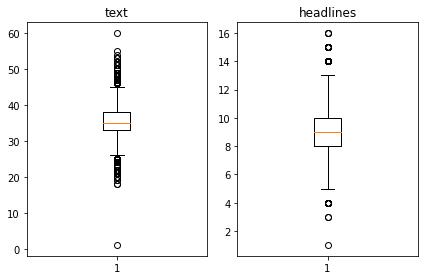

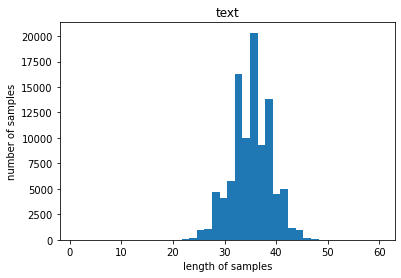

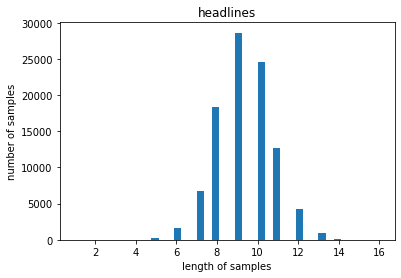

In [14]:
# 길이 분포 출력

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [15]:
# 위 Boxplot 참고하여 text의 최대 길이와 headline의 적절한 최대 길이를 임의로 정함

text_max_len = 45
headlines_max_len = 13

In [16]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [17]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 45 이하인 샘플의 비율: 0.9967771451809678
전체 샘플 중 길이가 13 이하인 샘플의 비율: 0.9981699877999186


In [18]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 (이전 98360) :', (len(data)))

전체 샘플수 (이전 98360) : 97863


#### 시작 토큰과 종료 토큰 추가하기

In [19]:
# 해드라인 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [20]:
# 각각 다시 Numpy 타입으로 저장
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

#### 훈련 데이터와 테스트 데이터를 분리

In [21]:
# 분리 패키지를 사용하는 방법, 또는 직접 코딩을 통해서 분리하는 방법중 직접코딩으로 분리
# 우선, encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 만들어줌
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[50532 26232 47022 ... 85363 14609 48729]


In [22]:
# 이 정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의해 주면 잘 섞인 샘플이 됨
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [23]:
# 섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19572


In [24]:
# 데이터 분리
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78291
훈련 레이블의 개수 : 78291
테스트 데이터의 개수 : 19572
테스트 레이블의 개수 : 19572


### 2-3. 정수 인코딩

#### 단어 집합(vocabulary) 만들기 및 정수 인코딩

In [25]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [26]:
# 빈도수가 낮은 단어들은 훈련 데이터에서 제외, 우선 7회 미만 빈도수 확인

threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69227
등장 빈도가 6번 이하인 희귀 단어의 수: 47159
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22068
단어 집합에서 희귀 단어의 비율: 68.12226443439698
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.4922582706634056


In [27]:
# 희귀 단어를 제외한 단어집합 22115와 비슷한 20000개로 제한
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 20000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [28]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[81, 404, 516, 56, 178, 3443, 3, 13, 52, 284, 1219, 6044, 1270, 1724, 258, 392, 7625, 52, 3222, 804, 1347, 1270, 1724, 134, 5859, 1079, 143, 4948, 2585, 1161, 27], [2, 1705, 303, 1179, 19, 2963, 1884, 55, 443, 19, 109, 144, 2, 3341, 928, 577, 5, 102, 707, 904, 212, 19, 109, 1284, 11, 1179, 2972, 175, 12, 22], [40, 2, 287, 1284, 122, 615, 587, 391, 19, 192, 615, 1725, 2152, 1001, 2, 1147, 25, 772, 179, 2644, 247, 587, 6, 287, 17, 73, 709, 137]]


#### target에 대해서도 동일과정 진행

In [29]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [30]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30033
등장 빈도가 5번 이하인 희귀 단어의 수: 19643
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10390
단어 집합에서 희귀 단어의 비율: 65.40472147304631
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.6722348206982405


In [31]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 2787, 1108, 42, 20, 41, 779, 3788, 604, 4, 369], [1, 8, 30, 91, 359, 1130, 5384, 625, 30, 130], [1, 94, 8, 3, 195, 1375, 4, 502, 6, 30, 234], [1, 2917, 9498, 119, 4, 216, 16, 416, 598, 3, 436, 262, 6, 443], [1, 3481, 1074, 219, 46, 8176, 1131, 633, 117]]
target
decoder  [[2787, 1108, 42, 20, 41, 779, 3788, 604, 4, 369, 2], [8, 30, 91, 359, 1130, 5384, 625, 30, 130, 2], [94, 8, 3, 195, 1375, 4, 502, 6, 30, 234, 2], [2917, 9498, 119, 4, 216, 16, 416, 598, 3, 436, 262, 6, 443, 2], [3481, 1074, 219, 46, 8176, 1131, 633, 117, 2]]


#### 요약문의 길이가 1인 경우 제거하기

In [32]:
# 희귀단어 제외로 인한 headlines 문장길이 0 (실제로는 시작/종료 토큰이 있어 1)이 된 샘플 삭제

drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 1
훈련 데이터의 개수 : 78291
훈련 레이블의 개수 : 78291
테스트 데이터의 개수 : 19571
테스트 레이블의 개수 : 19571


#### 테스트 데이터에서 1개의 샘플이 삭제 되었다.

#### 패딩하기

In [33]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')
print(encoder_input_train[:1])
print(encoder_input_test[:1])
print(decoder_input_train[:1])
print(decoder_target_train[:1])
print(decoder_input_test[:1])
print(decoder_target_test[:1])

[[  81  404  516   56  178 3443    3   13   52  284 1219 6044 1270 1724
   258  392 7625   52 3222  804 1347 1270 1724  134 5859 1079  143 4948
  2585 1161   27    0    0    0    0    0    0    0    0    0    0    0
     0    0    0]]
[[  654    56    93    17   320  1793  1761   710   106 19051   123    44
    654  1368  1421   320   198    44   123   527   117  1121   123    44
   1566  1875  3936  1402   654   123  5019  7023     0     0     0     0
      0     0     0     0     0     0     0     0     0]]
[[   1 2787 1108   42   20   41  779 3788  604    4  369    0    0]]
[[2787 1108   42   20   41  779 3788  604    4  369    2    0    0]]
[[  1 222 365  72   5  50   0   0   0   0   0   0   0]]
[[222 365  72   5  50   2   0   0   0   0   0   0   0]]


#### 패딩이 잘 이루어졌다.

## Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)

### 3-1. 인코더 설계

In [34]:
# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
# encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
# encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

### 3-2. 디코더 설계

In [35]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [36]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

### 3-3. 어텐션 메커니즘

In [37]:
# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

### 3-4. 모델 훈련하기

In [38]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
306/306 [==============================] - 37s 100ms/step - loss: 5.2353 - val_loss: 4.8169
Epoch 2/50
306/306 [==============================] - 30s 99ms/step - loss: 4.6810 - val_loss: 4.4841
Epoch 3/50
306/306 [==============================] - 31s 102ms/step - loss: 4.3599 - val_loss: 4.2056
Epoch 4/50
306/306 [==============================] - 32s 106ms/step - loss: 4.1090 - val_loss: 4.0383
Epoch 5/50
306/306 [==============================] - 32s 106ms/step - loss: 3.9177 - val_loss: 3.9149
Epoch 6/50
306/306 [==============================] - 32s 105ms/step - loss: 3.7657 - val_loss: 3.8272
Epoch 7/50
306/306 [==============================] - 32s 106ms/step - loss: 3.6316 - val_loss: 3.7339
Epoch 8/50
306/306 [==============================] - 32s 105ms/step - loss: 3.5143 - val_loss: 3.6701
Epoch 9/50
306/306 [==============================] - 32s 106ms/step - loss: 3.4090 - val_loss: 3.6146
Epoch 10/50
306/306 [==============================] - 32s 106ms/step - lo

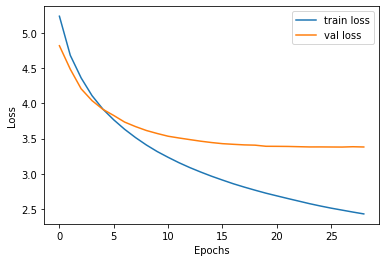

In [39]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)

### 4-1. 인퍼런스 모델 구현하기

In [40]:
# 테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하므로,
# 필요한 3개의 사전을 아래와 같이 미리 준비
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [41]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [42]:
# 어텐션 메커니즘을 사용하는 출력층을 설계

# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [43]:
# 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수

def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

### 4-2. 모델 테스트하기

In [44]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [45]:
for i in range(100, 150):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headlines(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : managing director indian public sector lender punjab national bank sunil mehta put branches investigation asked loss making branches either shape within year face closure merger however clarified loss making marginally profit making pnb branches across country 
실제 요약 : shape up or face closure pnb chief to loss making branches 
예측 요약 :  govt seeks cr from fraud against aditya reports


원문 : per reports sonam kapoor marrying businessman anand ahuja mumbai april earlier reports getting married switzerland may sonam family reportedly could host wedding choice resort pre booked saudi princess dates 
실제 요약 : sonam to marry anand ahuja in mumbai on april reports 
예측 요약 :  sonam kapoor to get married on wedding reports


원문 : akhil bharatiya vidyarthi parishad five key posts university hyderabad students union elections gap eight years aarti phd psychology student become second female president university history defeated naveen kumar students federation india margin votes 
실제 요약 : abvp 

#### 요약성능 분석

50개의 예측 요약 샘플 중 절반정도는 실제 용약과 비슷한 의미로 요약되었고 나머지도 의미는 다르지만 최소한 실제 요약문에 있는 핵심 단어들이 예측 요약 문장 안에 포함되어있다.

많은 예측 요약문이 완벽한 문장을 구성하지 못했거나 문법이 맞지 않는 문제점을 보인다.

## Step 5. Summa을 이용해서 추출적 요약해보기

### 5-1. 패키지 설치

In [46]:
! pip list | grep summa

summa                         1.2.0


### 5-2. 라이브러리 Import

In [47]:
import summa
from summa.summarizer import summarize

### 5-3. summarize 사용하여 요약하기

#### Summa의 summarize()의 인자로 사용되는 값

- text (str) : 요약할 테스트.
- ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값
- words (int or None, optional) – 출력에 포함할 단어 수.
  만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.
- split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환

In [48]:
# 가공되기 전의 원문을 다시 읽어와 요약
data_Org = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
for i in range(100, 150):
    print("원문 :", data_Org['text'][i])
    print("실제 요약 :", data_Org['headlines'][i])
    print("예측 요약 :", summarize(data_Org['text'][i], words=16)) 
    print("\n")

원문 : German multinational engineering and electronics firm Bosch has made its first investment in India in Bengaluru-based deep-tech startup SimYog. SimYog has raised about Ã¢ÂÂ¹6.3 crore in the funding round, with participation from early-stage venture capital firm Ideaspring Capital. Incubated at the Indian Institute of Science (IISc), it provides design and sign-off tools for automotive electronics.
실제 요약 : Bosch makes its 1st India investment in IISc spinoff SimYog
예측 요약 : 


원문 : Mumbai-headquartered talent technology startup Shortlist has raised $2 million in a Series A round of funding. The round was led by Blue Haven Initiative, with participation from Compass Venture Capital, Zephyr Acorn among others. Founded by Simon Desjardins, Paul Breloff and Matt Schnuck, Shortlist screens candidates using predictive chat-based interviews and online competency-based assessments.
실제 요약 : Mumbai's talent tech startup Shortlist raises $2 million
예측 요약 : Mumbai-headquartered talent technolo

#### 요약성능 분석

우선, '예측 요약'이 공란으로 비워진 경우가 있다. 이는 ratio값을 작게 하가나 words수를 작게 할수록 증가한다. 아직 summarize가 좀더 개발되어야 하겠다는 생각이 든다.

추출적요약은 본문 내용을 잘 나타낸다고 생각되는 한 문장을 선택하는 방법이므로 전혀 엉뚱한 요약을 하지는 않지만 성능이 그렇게 우수하지는 않은것같다.

본문 내용 중 적절한 한 문장을 추출하는 방식이므로 문장구성이나 문법은 당연히 우수할 수 밖에 없다.

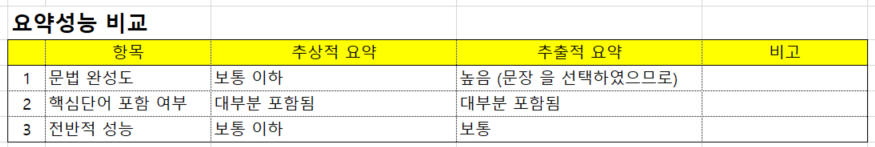

## 회고
### 이번 프로젝트에서 어려웠던 점

프로젝트 진행에 특별히 어려운점은 없었으나 요약의 성능을 높일 수 있는 방법이 딱히 떠오르지 않는다.

### 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점

추상적 요약에서 좋은 결과를 보여준적이 있었다. (50개 샘플 중 2개의 샘플에서 실제요약과 예측요약이 동일) 다른조건들을 이리 저리 바꾸어 보다가 요약성능이 나빠져서 좋았던 조건으로 다시 실행시켰으나 그 좋았던 성능이 나오지 않았다. 여러번 다시 돌려봐도.... 왜 일까....

### 루브릭 평가 지표를 맞추기 위해 시도한 것들

1. 불용어 제외를 False로 바꾸어 보았으나 결과가 좋지 않았다.
2. 불용어를 제외하지 않을때 "'" 부호를 제거하지 않도록 해 보았다. (I'm, didn't 등) 좋아지지 않았다.
3. optimizer rmsprop를 adam으로 바꾸어 보았다. 딱히 좋아지지 않았다.

### 만약에 루브릭 평가 관련 지표를 달성 하지 못했을 때, 이유에 관한 추정

특별히 달성해야 하는 명확한 기준이 없어 달성하지 못했다고 생각되지 않는다.

### 자기 다짐

NLP 분야는 관심이 있는데 어떻게 발전시켜야 하는지 아직 감이 잡히지 않는다. 과정 중 기회 될때마다 열심히 하고 과장이 끝난 이후에도 꾸준히 공부 하겠다.